In [1]:
# basic IO, etc
import io, os, shutil

# pull locations from overpass
import overpy

# get location files
import requests

# math
import matplotlib.pyplot as plt
from scipy.spatial import SphericalVoronoi, geometric_slerp#, cKDTree
import numpy as np

# geometry + data manipulation
import pandas as pd
import geopandas as gpd
import shapely
from pyproj import Proj, Transformer

# Used to do multi-processing
from multiprocessing import Pool
from functools import partial
from contextlib import contextmanager

# display  an image
from PIL import Image, ImageDraw
import IPython

In [2]:
@contextmanager
def poolcontext(*args, **kwargs):
    pool = Pool(*args, **kwargs)
    yield pool
    pool.terminate()

## Some Initial Set-Up

In [3]:
# number of processors
n_proc = 32 # Yay Ryzen 3950X (:

# create directories for input/output
os.makedirs("./data/", exist_ok=True)
os.makedirs("./output/", exist_ok=True)

# obtain the following geojson file of us states if not present
us_state_geojson_path = "./data/gz_2010_us_040_00_500k.json"
if not os.path.exists(us_state_geojson_path):
    url = "https://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_500k.json"
    r = requests.get(url)
    open(us_state_geojson_path, 'wb').write(r.content)
    
# overpass URL
overpass_url = "http://overpass-api.de/api/interpreter"
#overpass_url = "http://localhost:8091/api/interpreter"

## Some Spherical Geometry

In [4]:
# https://towardsdatascience.com/heres-how-to-calculate-distance-between-2-geolocations-in-python-93ecab5bbba4
def haversine_distance(lonlat1, lonlat2):
    earth_radius = 3958.8
    
    phi1 = np.radians(lonlat1[:,1])
    phi2 = np.radians(lonlat2[:,1])
    delta_phi = np.radians(lonlat2[:,1] - lonlat1[:,1])
    delta_lambda = np.radians(lonlat2[:,0] - lonlat1[:,0])

    a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2)**2
    res = earth_radius * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))
    
    return res

In [5]:
# Compute the maximum distance between p and any point in the vertices array
def max_dist_pt_to_verts(p_lonlat, vertices_lonlat):    
    distance_p_to_ext = haversine_distance(np.reshape(p_lonlat,(1,2)), vertices_lonlat)
    idx_max = np.argmax(distance_p_to_ext) 
    max_distance = distance_p_to_ext[idx_max]
    arg_max_lonlat = vertices_lonlat[idx_max]
     
    return max_distance, arg_max_lonlat

In [6]:
def lonlat_to_spherical(lonlat):
    if lonlat.ndim == 1:
        lonlat = lonlat.reshape((1, 2))
        
    phi   = np.radians(lonlat[:, 1]).ravel()
    theta = np.radians(lonlat[:, 0]).ravel()
    
    # spherical
    ps = np.zeros((phi.shape[0], 3))
    ps[:, 0] = np.cos(phi) * np.cos(theta)
    ps[:, 1] = np.cos(phi) * np.sin(theta)
    ps[:, 2] = np.sin(phi)
    
    return ps

In [7]:
def spherical_to_lonlat(ps):
    if ps.ndim == 1:
        ps = ps.reshape((1, 3))
   
    lonlat = np.zeros((ps.shape[0], 2))
    theta = np.arcsin(ps[:, 2])
    costheta = np.cos(theta)
    
    # invert
    lonlat[:, 1] = np.rad2deg(theta)    
    lonlat[:, 0] = np.rad2deg(np.arctan2(ps[:, 1] / costheta, ps[:, 0] / costheta))
    
    return lonlat    

In [8]:
def slerp_between_lonlat_pair(lonlat_start, lonlat_end, n_slerp = 5, endpoint=True):
    t = np.linspace(0, 1.0, n_slerp, endpoint=endpoint)
    p_start = lonlat_to_spherical(lonlat_start)
    p_end   = lonlat_to_spherical(lonlat_end)
    ps_slerp = geometric_slerp(p_start.ravel(), p_end.ravel(), t)
    lonlat_slerp = spherical_to_lonlat(ps_slerp)
    
    return lonlat_slerp    

In [9]:
def slerp_between_lonlat(lonlat, n_slerp = 5, close_loop=True):
    n_lonlat = lonlat.shape[0]    
    
    # early exit if we are only given a single point
    if lonlat.ndim == 1:
        return lonlat    
    lonlat = lonlat.reshape((-1, 2))
    
    
    if close_loop:
        n_total = n_slerp * n_lonlat + 1
    else:
        n_total = n_slerp * n_lonlat
        
    lonlat_slerp = np.zeros((n_total, 2))
    
    for i in range(n_lonlat):
        if i < n_lonlat - 1:
            start = lonlat[i, :]
            end = lonlat[i+1, :]
            
        else:
            start = lonlat[i, :]
            end = lonlat[0, :]
            
        lonlat_slerp[i * n_slerp : (i + 1) * n_slerp, :] = (
            slerp_between_lonlat_pair(start, end,n_slerp = n_slerp,endpoint = False)
        )
        
    if close_loop:
        lonlat_slerp[-1, :] = lonlat[0, :]
        
    return lonlat_slerp

## Obtain Locations Using Overpass API

In [10]:
def get_fastfood_locations(fast_food_locations, url=overpass_url):    
    api = overpy.Overpass(url=url)
    
    result = api.query("""
    (
      node["brand"~"^{0}"]["amenity"~"fast_food|restaurant"];
      way["brand"~"^{0}"]["amenity"~"fast_food|restaurant"];
      relation["brand"~"^{0}"]["amenity"~"fast_food|restaurant"];
    );
    out body;
    """.format(fast_food_chain)
    )
    
    return result.nodes

In [11]:
fast_food_query_results = dict()

fast_food_chain_list = [
    "McDonald's", "Burger King", "Wendy's"
]

fast_food_chain_list_alnum = [''.join(e for e in fast_food_chain if e.isalnum()) for 
                              fast_food_chain in fast_food_chain_list]

for fast_food_chain, fast_food_chain_pretty in zip(fast_food_chain_list, fast_food_chain_list_alnum):
    # save lat/lon results here
    fast_food_chain_location_csv = "./output/{}_Locations.csv".format(fast_food_chain_pretty)
    
    if not os.path.exists(fast_food_chain_location_csv):
        # query overpass
        location_results = get_fastfood_locations(fast_food_chain)
        
        # parse lat/lon and save to dict
        location_results = np.array([(float(n.lat), float(n.lon)) for n in location_results])
        fast_food_query_results[fast_food_chain] = location_results
        
        # write to file
        locations_df = pd.DataFrame(location_results, columns = ['lat', 'lon'])
        locations_df.to_csv(fast_food_chain_location_csv, index=False)
        
    else:
        # read the pre-existing file
        fast_food_query_results[fast_food_chain] = pd.read_csv(fast_food_chain_location_csv).to_numpy()
    
    # what all did we find?
    print("Found {} locations for {}.".format(len(fast_food_query_results[fast_food_chain]), 
                                              fast_food_chain))

Found 10527 locations for McDonald's.
Found 3912 locations for Burger King.
Found 1168 locations for Wendy's.


## Filter Locations to Lower 48 States

In [12]:
# US Map GeoJSON file obtained from: https://eric.clst.org/tech/usgeojson/
us_state_map = gpd.read_file(us_state_geojson_path)
us_state_map['lower_48'] = us_state_map['NAME'].apply(lambda x: x not in ['Alaska', 'Hawaii', 'Puerto Rico'])
us_state_map = us_state_map[us_state_map['lower_48'] == True]

# dissolve to get the states combined into one multi-polygon
usa_lower_48 = us_state_map.dissolve(by = 'lower_48')
usa_lower_48_geom = usa_lower_48.iloc[0].geometry

# only keep the biggest, since I can't be bothered to handle Spherical Multipolygons!
usa_lower_48_geom = [g for g in usa_lower_48_geom if g.area > 1]
usa_lower_48_geom = usa_lower_48_geom[0]

# get usa boundary lonlats
usa_lon, usa_lat = usa_lower_48_geom.boundary.coords.xy
usa_lon, usa_lat = usa_lon.tolist(), usa_lat.tolist()
usa_lonlat = np.array([usa_lon, usa_lat]).T

# use the usa centroid as an interior point for the spherical polygon
usa_centroid_lonlat = usa_lower_48_geom.centroid.coords.xy
usa_centroid_lonlat = np.array([usa_centroid_lonlat[0].tolist()[0], usa_centroid_lonlat[1].tolist()[0]])

# usa bb
us_bb_lonlat = np.array([
    [-150, 10],
    [ -60, 10],
    [ -60, 50],
    [-150, 50]
])

In [13]:
def lonlat_in_planar_poly(p, poly):
    return poly.contains(shapely.geometry.Point(p))

In [14]:
def filter_and_transform_lonlat_to_lower48(lon_lats, n_proc = 1):

    with poolcontext(processes = n_proc) as p:
        in_lower_48 = p.map(
            partial(lonlat_in_planar_poly, poly = usa_lower_48_geom), 
            lon_lats
        )

    # Filter and transform
    lon_lats = lon_lats[in_lower_48, :]
        
    return lon_lats

## Compute McFarthest Points

In [15]:
# Obtain the coordinates from the exterior boundary of a (multi)polygon
def exterior_boundary_vertex_coords(poly):
    if isinstance(poly, shapely.geometry.multipolygon.MultiPolygon):
        points = []
        for polygon in poly:
            points.extend(polygon.exterior.coords[:-1])
    
    elif isinstance(poly, shapely.geometry.polygon.Polygon):
        points = poly.exterior.coords[:-1]
    
    return points

In [16]:
def sort_vertices(vertices):
    mu = np.mean(vertices, axis = 0)
    angles = np.arctan2(vertices[:, 1] - mu[1], vertices[:, 0] - mu[0])
    idx_sorted = np.argsort(angles)
    vertices = vertices[idx_sorted, :]
    
    return vertices

In [17]:
# Obtain the coordinates from the exterior boundary of a (multi)polygon
def exterior_boundary_vertex_coords(poly):
    if isinstance(poly, shapely.geometry.multipolygon.MultiPolygon):
        points = []
        for polygon in poly:
            points.extend(polygon.exterior.coords[:-1])
    
    elif isinstance(poly, shapely.geometry.polygon.Polygon):
        points = poly.exterior.coords[:-1]
    
    return points

In [18]:
# Compute the polygon formed by intersecting the polygon formed by vertices with
# the (multi)polygon poly
def intersection_polygon(vertices, poly):
    # vertices for cell containing p
    qs = list(vertices)
    #qs.append(qs[0])
    qs = np.array(qs)
    
    # compute intersection of poly with voronoi cell
    cell_p = shapely.geometry.Polygon(qs).buffer(0)
    cell_p = poly.intersection(cell_p)    
    
    return cell_p

In [19]:
# Compute the vertices of the polygon formed by intersecting the polygon formed 
# by the points in the vertices array with the (multi)polygon poly
def intersection_polygon_vertices(vertices, poly):
    # compute intersection of poly with voronoi cell
    cell_p = intersection_polygon(vertices, poly)
    
    # vertices of intersection of p with poly
    restricted_cell_vertices = np.array(exterior_boundary_vertex_coords(cell_p))    
    
    return restricted_cell_vertices

In [20]:
# Sometimes a vertex will be on the other side of the planet. When this happens, 
# (since the US is in the western hemisphere), if the vertices are sorted CW on 
# the sphere, the longitude for subsequent vertices will go from negative to 
# positive, which screws up planar calculations. Fix this by translating 
# the bad points' longitudes by -360*
def shift_bad_latlon_poly(vertices):
    qq = slerp_between_lonlat(vertices, n_slerp=20)
        
    for j in range(len(qq) - 1):
        if abs(qq[j, 0] - qq[j + 1, 0]) > 180:
            if qq[j, 0] < 0:
                qq[j+1, 0] = qq[j+1, 0] - 360    
            elif qq[j, 0] > 0:
                qq[j, 0] = qq[j, 0] - 360
    return qq

In [21]:
def mcfarthest_in_poly(lonlat, poly, n_proc = 1):
    # Get ranges of points
    ps_sphere = lonlat_to_spherical(lonlat)
    ps_sphere.mean()
    
    # Add a point at "infinity": the antipodal point to mean(ps_sphere), and some
    # points around the equator perpendicular to the axis through these two points
    mu = ps_sphere.mean(axis = 0)
    mu = (1. / np.linalg.norm(mu)) * mu.ravel()
    ps_antipode = - mu.reshape((1, 3))
    ps_other = np.array([
      [mu[1], -mu[0], 0],   
      [-mu[1], mu[0], 0],   
      [mu[2], 0, -mu[0]],   
      [-mu[2], 0, mu[0]],           
      [0, mu[2], -mu[1]],         
      [0, -mu[2], mu[1]]
    ])    
    ps_other = ps_other / np.linalg.norm(ps_other, axis = 1).reshape((6, 1))
       
    # Add points at "infinity" and around the hemisphere  at "infinity to our collection"
    ps_sphere = np.concatenate([ps_sphere, ps_antipode, ps_other])
    
    # compute the voronoi diagram
    vor = SphericalVoronoi(ps_sphere, radius=1, threshold=1e-07) 
    vor.sort_vertices_of_regions()    
   
    # extract information from voronoi diagram and convert to lonlat
    vor_points = spherical_to_lonlat(vor.points)
    vor_p_regions = vor.regions    
    vor_cell_vertices = [spherical_to_lonlat(vor.vertices[l, :]) for l in vor.regions]
    vor_cell_vertices = [sort_vertices(v) for v in vor_cell_vertices]

    # find "bad" polygons, where the polygon goes out of the hemisphere the US is located in
    bad_polys_tuples = [(i, vor_cell_vertices[i]) for i in range(len(lonlat)) 
                        if vor_cell_vertices[i][:, 0].max() > 0]
    
    # shift "bad" vertices to left
    for i, bad_vertices in bad_polys_tuples:
        vor_cell_vertices[i] = shift_bad_latlon_poly(bad_vertices)
    
    # re-order the vertices
    restricted_cell_vertices = [sort_vertices(r) for r in vor_cell_vertices]   
        
    # restrict the vertices to the polygon
    # may be slow, so we run with multiprocessing
    with poolcontext(processes = n_proc) as p:
        restricted_cell_vertices = p.map(
            partial(intersection_polygon_vertices,
                    poly=poly
            ), 
            list(vor_cell_vertices)
        )
        
    # compute results
    cell_max_distance_vertex_pairs = [max_dist_pt_to_verts(p, cell) for p, cell 
                                      in zip(lonlat, restricted_cell_vertices[:len(lonlat)]) if len(cell) > 0]
    
    max_distance_idx = np.argmax([d for d,p in cell_max_distance_vertex_pairs])
    max_distance, mcfarthest = cell_max_distance_vertex_pairs[max_distance_idx]
    nearest_pt = lonlat[max_distance_idx, :]
    
    # return vor data in a dict
    voronoi_data = {'vor' : vor, 'restricted_cell_vertices' : restricted_cell_vertices, 'lonlat' : lonlat}
    
    return max_distance, mcfarthest, nearest_pt, voronoi_data

In [22]:
def mcfarthest_in_state(state_name, lonlat, us_state_map, n_proc = 1):
    state_gdf = us_state_map[us_state_map.NAME == state_name]
    state_geom = state_gdf.iloc[0].geometry        
    max_distance, mcfarthest, nearest_lonlat, vor = mcfarthest_in_poly(lonlat, state_geom, n_proc)
    
    return max_distance, mcfarthest, nearest_lonlat, vor

In [23]:
def mcfarthest_in_every_state(lonlat, us_state_map, n_proc = 1):
    state_names = us_state_map.NAME    
    max_distances = []
    mcfarthest_lonlats = []
    nearest_lonlats = []
    
    for state_name in state_names:
        state_gdf = us_state_map[us_state_map.NAME == state_name]
        state_geom = state_gdf.iloc[0].geometry        
        max_distance, mcfarthest_lonlat, nearest_lonlat, vor = mcfarthest_in_poly(lonlat, state_geom, n_proc)
        
        max_distances.append(max_distance)
        mcfarthest_lonlats.append(mcfarthest_lonlat)
        nearest_lonlats.append(nearest_lonlat)
        
    df_mcfarthest = pd.DataFrame({
        'state_name' : state_names,
        'max_distance' : max_distances,
        'mcfarthest_lonlat' : mcfarthest_lonlats,
        'nearest_lonlat' : nearest_lonlats
    })
    
    # convert the mcfarthest coordinates
    df_mcfarthest['mcfarthest_lat'] = df_mcfarthest['mcfarthest_lonlat'].apply(lambda p: p[1])
    df_mcfarthest['mcfarthest_lon'] = df_mcfarthest['mcfarthest_lonlat'].apply(lambda p: p[0])    

    # add/convert the nearest point 
    df_mcfarthest['nearest_lat'] = df_mcfarthest['nearest_lonlat'].apply(lambda p: p[1])
    df_mcfarthest['nearest_lon'] = df_mcfarthest['nearest_lonlat'].apply(lambda p: p[0])    
    
    # rearrange
    df_mcfarthest = df_mcfarthest[['state_name', 'mcfarthest_lat', 'mcfarthest_lon', 'max_distance', 'nearest_lat', 'nearest_lon', 'nearest_lonlat', 'mcfarthest_lonlat']]
    
    return df_mcfarthest

In [24]:
def mcfarthest_for_chain(fast_food_chain, fast_food_query_results, n_proc = 1):
    unfiltered_latlons = fast_food_query_results[fast_food_chain]
    unfiltered_latlons = np.array(list(set([tuple(p) for p in unfiltered_latlons])))
    unfiltered_lonlat = np.zeros_like(unfiltered_latlons)
    unfiltered_lonlat[:, 0], unfiltered_lonlat[:, 1] = unfiltered_latlons[:, 1], unfiltered_latlons[:, 0]
    lonlat = filter_and_transform_lonlat_to_lower48(unfiltered_lonlat, n_proc = n_proc)
    
    # compute mcfarthest points
    max_distance, mcfarthest_lonlat, nearest_lonlat, vor = mcfarthest_in_poly(lonlat, usa_lower_48_geom, n_proc)
    df_state_mcfarthest = mcfarthest_in_every_state(lonlat, us_state_map, n_proc = n_proc)
    
    # bundle results together
    mcfarthest_results = dict()
    mcfarthest_results['voronoi_diagram'] = vor
    mcfarthest_results['us_mcfarthest_lonlat'] = mcfarthest_lonlat
    mcfarthest_results['us_mcfarthest_distance'] = max_distance
    mcfarthest_results['us_nearest_lonlat'] = nearest_lonlat
    mcfarthest_results['df_state_mcfarthest'] = df_state_mcfarthest
    mcfarthest_results['state_mcfarthest_lonlats'] = np.array(df_state_mcfarthest['mcfarthest_lonlat'].to_list())
    mcfarthest_results['state_nearest_lonlats'] = np.array(df_state_mcfarthest['nearest_lonlat'].to_list())    
    mcfarthest_results['state_mcfarthest_distances'] = df_state_mcfarthest['max_distance'].to_numpy()
        
    return mcfarthest_results 

In [25]:
def mcfarthest_summary_for_chain(mcfarthest_results, fast_food_chain):
    # mcfarthest distance for us
    max_distance = mcfarthest_results["us_mcfarthest_distance"]
    
    # mcfarthest pt for US
    mcfarthest_lonlat = mcfarthest_results["us_mcfarthest_lonlat"]    
    mcfarthest_lon, mcfarthest_lat = mcfarthest_lonlat[0], mcfarthest_lonlat[1]
    
    # nearest for US
    nearest_lonlat = mcfarthest_results["us_nearest_lonlat"]    
    nearest_lon, nearest_lat = nearest_lonlat[0], nearest_lonlat[1]
    
    # place US mcfarthest data in df
    dfus = pd.DataFrame({
        "region" : "US", 
        "max_distance" : [max_distance],         
        "mcfarthest_lat" : [mcfarthest_lat], 
        "mcfarthest_lon" : [mcfarthest_lon], 
        "nearest_lat" : [nearest_lat], 
        "nearest_lon" : [nearest_lon]
    })

    # state results
    dfstate = (mcfarthest_results["df_state_mcfarthest"]
         .sort_values("state_name")
         .rename(columns = {"state_name" : "region"})
    )
    dfstate = dfstate[["region", "max_distance", "mcfarthest_lat", "mcfarthest_lon", "nearest_lat", "nearest_lon"]]
    
    # concatenate US and state results
    dfcomb = pd.concat([dfus, dfstate])
    dfcomb["max_distance_miles"] = dfcomb["max_distance"] # they're the same here
    dfcomb = dfcomb[["region", "max_distance_miles", "mcfarthest_lat", "mcfarthest_lon", "nearest_lat", "nearest_lon"]]
    
    return dfcomb

## Plot the Results

In [26]:
def plot_voronoi_result(lonlats, voronoi_cells, bounding_poly_df,  ax = None):
    if ax == None:
        fig, ax = plt.subplots()
        
    bounding_poly_df.plot(ax = ax, color = 'None', edgecolor='k', linewidth = 2, zorder = 10)
    xrange, yrange = ax.get_xlim(), ax.get_ylim()
    
    # draw the Voronoi regions (as Euclidean polygons)
    for cell, ll in zip(voronoi_cells, lonlats):
        cell_boundary = slerp_between_lonlat(cell, close_loop = True)
        # reshape degenerate case
        cell_boundary = cell_boundary.reshape((-1, 2)) 
        ax.plot(cell_boundary[:, 0], cell_boundary[:, 1], c='dimgray', zorder = 0, linewidth = 0.75)    
        
    # plot the points
    ax.scatter(lonlats[:, 0], lonlats[:, 1], c='C0', s=4)

    # pretty up the plot
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    ax.set_xlim(xrange)
    ax.set_ylim(yrange)    
    
    return ax

In [27]:
def plot_mcfarthest_result(mcfarthest, lonlats, voronoi_cells, bounding_poly_df, ax = None):
    ax = plot_voronoi_result(lonlats, voronoi_cells, bounding_poly_df, ax = ax)    
    ax.scatter(mcfarthest[0], mcfarthest[1], c='C3', zorder=1000)
    
    return ax

In [28]:
def plot_single_state_mcfarthest(state_name, mcfarthest, lonlats, voronoi_cells, ax = None):
    state_gdf = us_state_map[us_state_map.NAME == state_name]
    ax = plot_mcfarthest_result(mcfarthest, lonlats, voronoi_cells, state_gdf, ax = ax)
   
    return ax

In [29]:
def plot_mcfarthest_for_chain(fast_food_chain, chain_mcfarthest_results, ax = None):
    if ax is None:
        fig, ax = plt.subplots(figsize = (12, 6))
    else:
        fig = plt.gcf()
        
    # plot the voronoi diagram with chain locations
    ax = plot_voronoi_result(
        chain_mcfarthest_results['voronoi_diagram']['lonlat'],
        chain_mcfarthest_results['voronoi_diagram']['restricted_cell_vertices'], 
        usa_lower_48, 
        ax = ax
    )
    
    # plot some blank entries to add legend entries for cells and chain locations
    ax.plot([], c = 'dimgray', label = "Voronoi Cells")
    ax.scatter([], [], c = 'C0', label = "{} Locations".format(fast_food_chain))    
     
    # overlay the US map on the plot
    us_state_map.plot(ax = ax, color='None', edgecolor='k', zorder=1000)
    
    # plot each state's mcfarthest point
    ax.scatter(
        chain_mcfarthest_results['state_mcfarthest_lonlats'][:, 0], 
        chain_mcfarthest_results['state_mcfarthest_lonlats'][:, 1], 
        c = 'C3', 
        zorder=2000,
        edgecolor = 'k',
        linewidths = 1,    
        label = "Statewide McFarthest"    
    )
    
    # plot the nationwide (well lower 48) mcfarthest with a fancy star
    ax.scatter(
        chain_mcfarthest_results['us_mcfarthest_lonlat'][0],
        chain_mcfarthest_results['us_mcfarthest_lonlat'][1],
        c = 'y',
        zorder = 3000,
        s = 225,
        marker = "*",
        edgecolor = 'k',
        linewidths = 1.25,
        label = "Nationwide McFarthest"
    )
    
    # tidy up the plot
    ax.set_title("McFarthest Points for {}".format(fast_food_chain))
    fig.patch.set_facecolor('w')
    ax.legend(loc = 'lower right')
    
    return ax

### Traditional McFarthest Point

In [30]:
mcdonalds_mcfarthest_results = mcfarthest_for_chain("McDonald's", fast_food_query_results, n_proc = n_proc)
mcdonalds_df_mcfarthest = mcdonalds_mcfarthest_results['df_state_mcfarthest']

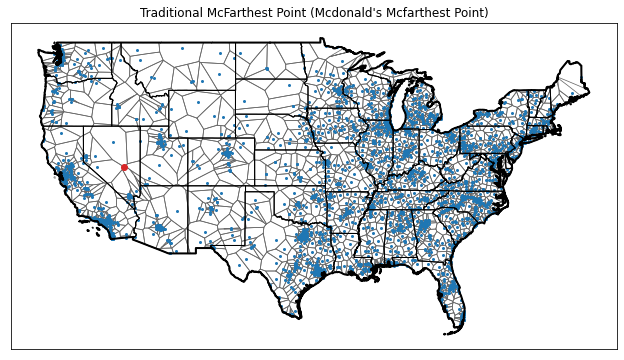

In [31]:
fig, ax = plt.subplots(figsize = (12, 6), facecolor='white')
ax = plot_mcfarthest_result(
    mcdonalds_mcfarthest_results['us_mcfarthest_lonlat'], 
    mcdonalds_mcfarthest_results['voronoi_diagram']['lonlat'],
    mcdonalds_mcfarthest_results['voronoi_diagram']['restricted_cell_vertices'], 
    usa_lower_48,     
    ax = ax
)
us_state_map.plot(ax = ax, color='None', edgecolor='k')
ax.set_title("Traditional McFarthest Point (Mcdonald's Mcfarthest Point)");

### McFarthest Points for Selected States

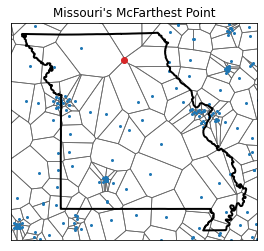

In [32]:
state_name = 'Missouri'
state_mcfarthest = mcdonalds_df_mcfarthest[mcdonalds_df_mcfarthest['state_name'] == state_name]['mcfarthest_lonlat'].iloc[0]
lonlat = mcdonalds_mcfarthest_results['voronoi_diagram']['lonlat']
restricted_cell_vertices = mcdonalds_mcfarthest_results['voronoi_diagram']['restricted_cell_vertices']
fig, ax = plt.subplots(facecolor = 'white')
plot_single_state_mcfarthest(state_name, state_mcfarthest, lonlat, restricted_cell_vertices, ax = ax);
ax.set_title("{}'s McFarthest Point".format(state_name));

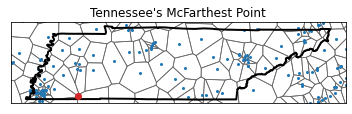

In [33]:
state_name = 'Tennessee'
state_mcfarthest = mcdonalds_df_mcfarthest[mcdonalds_df_mcfarthest['state_name'] == state_name]['mcfarthest_lonlat'].iloc[0]
lonlat = mcdonalds_mcfarthest_results['voronoi_diagram']['lonlat']
restricted_cell_vertices = mcdonalds_mcfarthest_results['voronoi_diagram']['restricted_cell_vertices']
fig, ax = plt.subplots(facecolor = 'white')
plot_single_state_mcfarthest(state_name, state_mcfarthest, lonlat, restricted_cell_vertices, ax = ax);
ax.set_title("{}'s McFarthest Point".format(state_name));

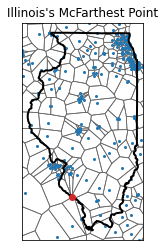

In [34]:
state_name = 'Illinois'
state_mcfarthest = mcdonalds_df_mcfarthest[mcdonalds_df_mcfarthest['state_name'] == state_name]['mcfarthest_lonlat'].iloc[0]
lonlat = mcdonalds_mcfarthest_results['voronoi_diagram']['lonlat']
restricted_cell_vertices = mcdonalds_mcfarthest_results['voronoi_diagram']['restricted_cell_vertices']
fig, ax = plt.subplots(facecolor = 'white')
plot_single_state_mcfarthest(state_name, state_mcfarthest, lonlat, restricted_cell_vertices, ax = ax);
ax.set_title("{}'s McFarthest Point".format(state_name));

## Note: pretty much inexplicably, it really is Illinois's. Grammar is dumb... see below:
# https://www.chicagomanualofstyle.org/qanda/data/faq/topics/PossessivesandAttributives/faq0046.html

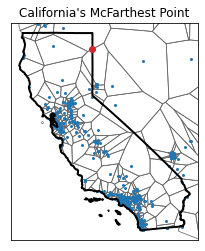

In [35]:
state_name = 'California'
state_mcfarthest = mcdonalds_df_mcfarthest[mcdonalds_df_mcfarthest['state_name'] == state_name]['mcfarthest_lonlat'].iloc[0]
lonlat = mcdonalds_mcfarthest_results['voronoi_diagram']['lonlat']
restricted_cell_vertices = mcdonalds_mcfarthest_results['voronoi_diagram']['restricted_cell_vertices']
fig, ax = plt.subplots(facecolor = 'white')
plot_single_state_mcfarthest(state_name, state_mcfarthest, lonlat, restricted_cell_vertices, ax = ax);
ax.set_title("{}'s McFarthest Point".format(state_name));

### McFarthest Points for All Lower 48 States

In [36]:
# save csv with results, and print nation wide result
df_mcdconalds_mcfarthest = mcfarthest_summary_for_chain(mcdonalds_mcfarthest_results, "McDonald's")
df_mcdconalds_mcfarthest.to_csv("./output/McDonalds_McFarthest.csv", index=False)

# print results 
with pd.option_context('display.precision', 2):
    html = (df_mcdconalds_mcfarthest
            .set_index('region')
            .sort_values('max_distance_miles', ascending=False)
            .reset_index()
            .head(n = 5)
            .style
            .hide_index())
html

region,max_distance_miles,mcfarthest_lat,mcfarthest_lon,nearest_lat,nearest_lon
US,154.10,38.60,-115.77,36.80,-114.10
Nevada,154.10,38.60,-115.77,36.09,-79.77
North Dakota,153.70,49.00,-100.04,40.76,-73.83
Utah,153.69,37.14,-110.14,30.06,-94.80
Oregon,148.75,42.23,-118.88,42.59,-114.46


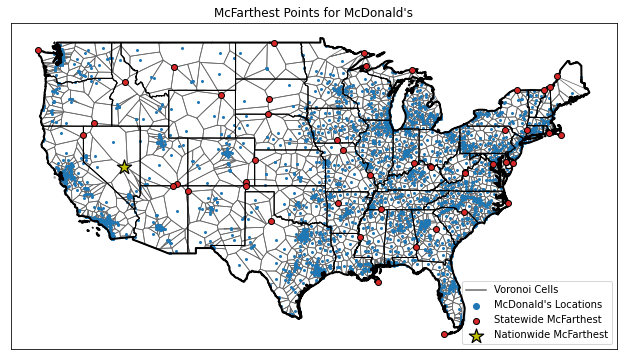

In [37]:
plot_mcfarthest_for_chain("McDonald's", mcdonalds_mcfarthest_results);

## Burger King's McFarthest Points

In [38]:
burgerking_mcfarthest_results = mcfarthest_for_chain('Burger King', fast_food_query_results, n_proc = n_proc)

In [39]:
# save csv with results, and print nation wide result
df_burgerking_mcfarthest = mcfarthest_summary_for_chain(burgerking_mcfarthest_results, "Burger King")
df_burgerking_mcfarthest.to_csv("./output/BurgerKing_McFarthest.csv", index=False)

# print results 
with pd.option_context('display.precision', 2):
    html = (df_burgerking_mcfarthest
            .set_index('region')
            .sort_values('max_distance_miles', ascending=False)
            .reset_index()
            .head(n = 5)
            .style
            .hide_index())
html

region,max_distance_miles,mcfarthest_lat,mcfarthest_lon,nearest_lat,nearest_lon
US,280.45,49.00,-111.79,47.63,-117.54
Montana,280.45,49.00,-111.79,41.70,-88.12
Maine,209.82,47.35,-68.23,35.64,-78.84
Minnesota,200.37,48.58,-92.84,41.70,-88.12
South Dakota,188.74,43.74,-101.81,38.84,-77.43


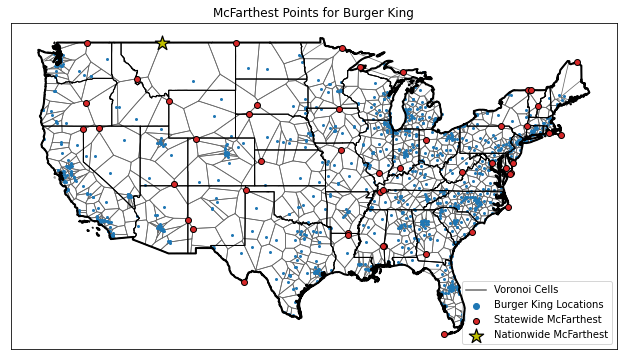

In [40]:
plot_mcfarthest_for_chain('Burger King', burgerking_mcfarthest_results);

## Wendy's McFarthest Points

In [41]:
wendys_mcfarthest_results = mcfarthest_for_chain("Wendy's", fast_food_query_results, n_proc = n_proc)

In [42]:
# save csv with results, and print nation wide result
df_wendys_mcfarthest = mcfarthest_summary_for_chain(wendys_mcfarthest_results, "Wendy's")
df_wendys_mcfarthest.to_csv("./output/Wendys_McFarthest.csv", index=False)

# print results 
with pd.option_context('display.precision', 2):
    html = (df_wendys_mcfarthest
            .set_index('region')
            .sort_values('max_distance_miles', ascending=False)
            .reset_index()
            .head(n = 5)
            .style
            .hide_index())
html

region,max_distance_miles,mcfarthest_lat,mcfarthest_lon,nearest_lat,nearest_lon
US,312.32,47.07,-67.79,44.50,-73.12
Maine,312.32,47.07,-67.79,34.06,-78.88
Wyoming,270.50,44.75,-111.03,37.24,-81.25
Montana,269.56,44.77,-111.06,38.54,-89.98
Idaho,258.98,44.62,-111.22,38.54,-89.98


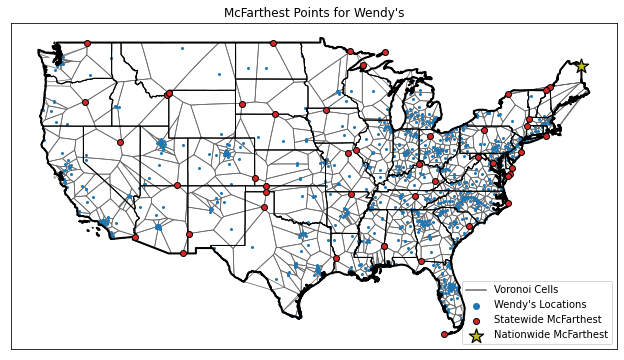

In [43]:
plot_mcfarthest_for_chain("Wendy's", wendys_mcfarthest_results);

## McFarthest Point Stability

In [44]:
fast_food_chain = "McDonald's"
lonlat = mcdonalds_mcfarthest_results['voronoi_diagram']['lonlat']

In [45]:
%%time

bufs = []
ims = [] 

# we'll re-draw on the same figure
fig, ax = plt.subplots(facecolor = 'white', figsize = (12, 6))

# prepare the figures for animation
for n_lonlats in range(3, len(lonlat), 50):
    # compute the mcfarthest using only n_lonlats points 
    max_distance, mcfarthest_lonlat, nearest_lonlat, voronoi_results = mcfarthest_in_poly(lonlat[0:n_lonlats, :], usa_lower_48_geom, n_proc)

    # draw the image
    plt.cla()
    plot_mcfarthest_result(
        mcfarthest_lonlat, 
        voronoi_results['lonlat'], 
        voronoi_results['restricted_cell_vertices'],
        usa_lower_48, 
        ax = ax
    )
    ax.set_title("McFarthest Point for {} using {}/{} Locations".format(fast_food_chain, n_lonlats, len(lonlat)))
    
    # write the image to a buffer to feed to 
    # PIL on in-RAM buffer: https://stackoverflow.com/a/8598881
    buf = io.BytesIO()    
    plt.savefig(buf, format='png', bbox_inches='tight')
    buf.seek(0)
    im = Image.open(buf)
    
    # add im to list of ims
    ims.append(im)

# animate the result
gif_duration_seconds = 10
ims[0].save("./output/mcfarthest_stability.gif", save_all=True, append_images=ims[1:], optimize=True, 
            duration=(gif_duration_seconds * 1000) / len(ims), loop=0, quality = 50)

# close figure to avoid displaying it
plt.close(fig)

# release the buffers
for buf in bufs:
    buf.close()

CPU times: user 12min 21s, sys: 23.1 s, total: 12min 44s
Wall time: 10min 8s


In [46]:
# decrease file size if ImageMagick is present
if shutil.which('mogrify') is not None:
    os.system("mogrify -layers 'optimize' -fuzz 7% ./output/mcfarthest_stability.gif")

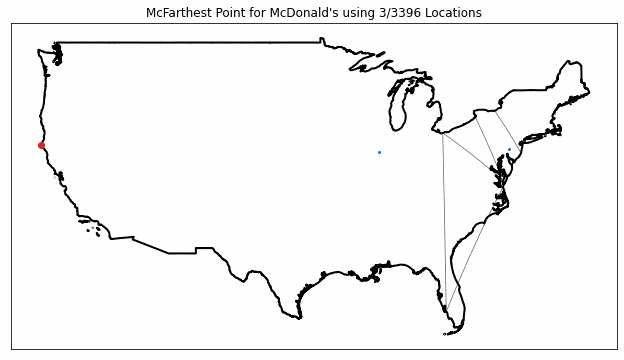

In [47]:
IPython.display.Image("./output/mcfarthest_stability.gif")

## Spherical Plot Example

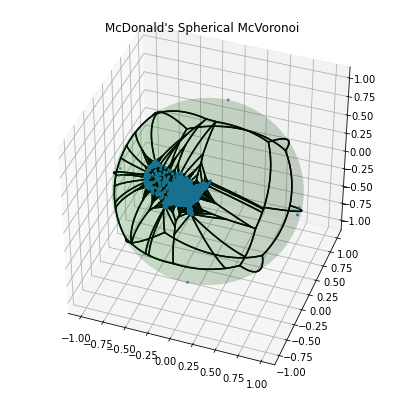

In [48]:
# adapted from https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.SphericalVoronoi.html

fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(111, projection='3d')

vor = mcdonalds_mcfarthest_results['voronoi_diagram']['vor']

# plot the unit sphere for reference (optional)
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = np.outer(np.cos(u), np.sin(v))
y = np.outer(np.sin(u), np.sin(v))
z = np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_surface(x, y, z, color='g', alpha=0.1)

# plot the cell seeds
pp = vor.points
ax.scatter(pp[:, 0], pp[:, 1], pp[:, 2], s = 4)

# parameter for slerping between vertices
t_vals = np.linspace(0, 1, 100)

# indicate Voronoi regions (as Euclidean polygons)
for region in vor.regions:
    n = len(region)
    for i in range(n):
        start = vor.vertices[region][i]
        end = vor.vertices[region][(i + 1) % n]
        # slerp between vertices
        result = geometric_slerp(start, end, t_vals)
        ax.plot(result[..., 0],
                result[..., 1],
                result[..., 2], 
                c='k')

# rotate globe to put US in frame
ax.azim = -70
ax.elev = 40

# a good title.
ax.set_title("McDonald's Spherical McVoronoi")
plt.show()